# Example with failed steady state and whether there's a different notation for BR and HEOM dynamics' density matrix

### imports (this is supposed to be cole of the master branch )

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom

### Hamiltonian and coupling operator

In [48]:
H=tensor(qeye(2),sigmaz())+ tensor(sigmaz(),qeye(2))
Q=tensor(qeye(2),sigmax()) + tensor(sigmax(),qeye(2)) 

### Bath parameters

In [54]:
lam=0.5
gamma=1
w0=1
T=1
times=np.linspace(0,300,500) #long time to reach steady state

In [55]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=T, Nk=5) # fix runtime warning

### initial state (irrelevant for the steady state discussion but relevant for the transpose/conjugate thing)

In [56]:
N=2
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()

In [57]:
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

### Solving dynamics and steady state

In [58]:
solver = heom.HEOMSolver(H,
                          [bath], max_depth=3, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   0.94s. Est. time left: 00:00:00:08
20.0%. Run time:   1.82s. Est. time left: 00:00:00:07
30.1%. Run time:   2.57s. Est. time left: 00:00:00:05
40.1%. Run time:   3.32s. Est. time left: 00:00:00:04
50.1%. Run time:   4.10s. Est. time left: 00:00:00:04
60.1%. Run time:   4.95s. Est. time left: 00:00:00:03
70.1%. Run time:   5.99s. Est. time left: 00:00:00:02
80.2%. Run time:   6.75s. Est. time left: 00:00:00:01
90.2%. Run time:   7.53s. Est. time left: 00:00:00:00
100.0%. Run time:   8.25s. Est. time left: 00:00:00:00
Total run time:   8.25s


In [59]:
steady_state, steady_ados = solver.steady_state()

### Power spectrum for redfield

In [23]:

UD = (
    f"2 * {lam}**2 * {gamma} / ( {w0}**4 * {1/T}) if (w==0)"
    " else "
    f"2 * ({lam}**2 * {gamma} * w / (({w0}**2 - w**2)**2 + {gamma}**2 * w**2))"
    f" * ((1 / (exp(w * {1/T}) - 1)) + 1)"
)

### Redfield solution

In [20]:
a_ops = [[Q, UD]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

NameError: name 'UD' is not defined

### Calculating fidelity with and without conjugate

In [62]:
f=np.array([ fidelity(resultBR.states[k],state) for k,state in enumerate(result.states)])
fcon=np.array([ fidelity(resultBR.states[k].conj(),state) for k,state in enumerate(result.states)])

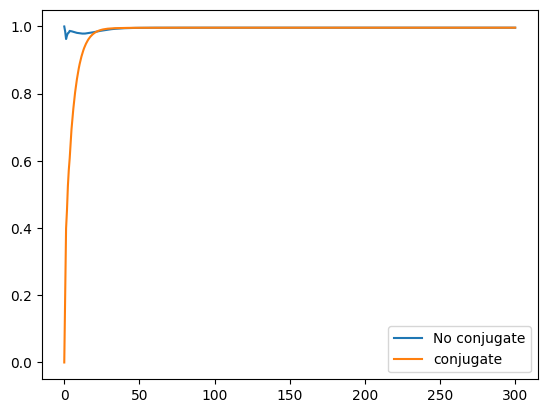

In [63]:
plt.plot(times,f,label="No conjugate")
plt.plot(times,fcon,label="conjugate")
plt.legend()

### observing the evolution of the imaginary part of one of the coherences

In [64]:
she=np.array([j[2,1] for j in result.states])
sbr=np.array([j[2,1] for j in resultBR.states])

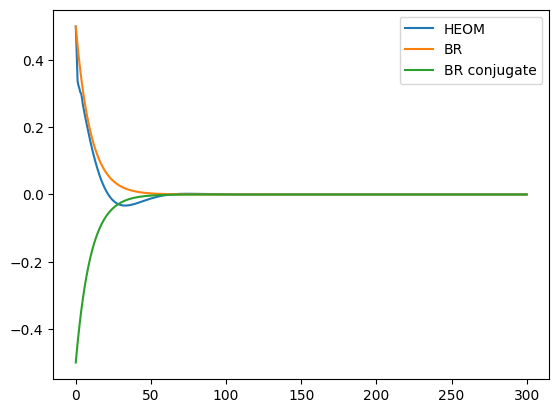

In [65]:
plt.plot(times,np.imag(she),label="HEOM")
plt.plot(times,np.imag(sbr),label="BR")
plt.plot(times,-np.imag(sbr),label="BR conjugate")
plt.legend()

### observing populations (mainly so I can tell dynamics reached the steady state)

In [66]:
she=np.array([j[0,0] for j in result.states])
sbr=np.array([j[0,0] for j in resultBR.states])

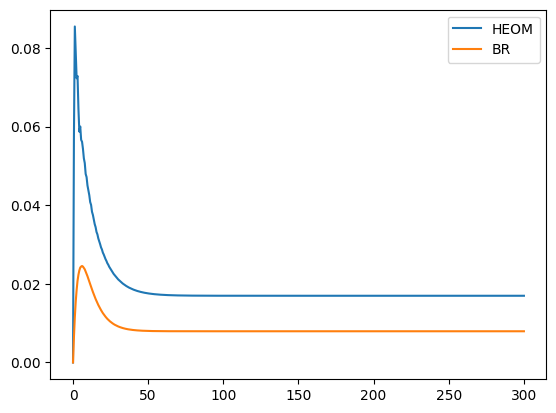

In [67]:
plt.plot(times,she,label="HEOM")
plt.plot(times,sbr,label="BR")
plt.legend()

### Comparing the steady state from the solver and the dynamics

In [71]:
steady_state

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.58299105e-17  0.00000000e+00  0.00000000e+00  1.47454307e-17]
 [ 0.00000000e+00  5.00000000e-01 -5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00 -5.00000000e-01  5.00000000e-01  0.00000000e+00]
 [ 1.47454307e-17  0.00000000e+00  0.00000000e+00 -2.80353456e-17]]

In [72]:
result.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.01696806+8.65219338e-18j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.01977594-1.34022685e-16j]
 [ 0.        +0.00000000e+00j  0.29600475+7.61598129e-17j
  -0.20399525+8.52079792e-10j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.20399525-8.52079858e-10j
   0.29600475+1.71210943e-18j  0.        +0.00000000e+00j]
 [ 0.01977594+1.38576400e-16j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.39102243-8.80899752e-17j]]

In [73]:
resultBR.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 7.93811999e-03  0.00000000e+00  0.00000000e+00  1.41999527e-14]
 [ 0.00000000e+00  2.79327607e-01 -2.20672393e-01  0.00000000e+00]
 [ 0.00000000e+00 -2.20672393e-01  2.79327607e-01  0.00000000e+00]
 [-1.92284162e-14  0.00000000e+00  0.00000000e+00  4.33406666e-01]]

### Another example because the Conjugate vs no conjugate is important to me right now (if there's no conjugate the cumulant equation is way better for spin chains so yay! probably can squeeze a paper out of it, probably should check time dependent redfield), and from here it seems like I should not take it

- [ ] Confirm conjugate should not be there (probably using bloch redfield by hand 🤔)
- [ ] Compare with time dependent Redfield

#### same steps as before

In [24]:
H=sigmaz()
Q=sigmax()

In [25]:
rho0=Qobj([[1,1],[1,1]])/2

In [29]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=T, Nk=5) # fix runtime warning

In [17]:
times=np.linspace(0,300,500)

In [31]:
solver = heom.HEOMSolver(H,
                          [bath], max_depth=5, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   1.86s. Est. time left: 00:00:00:16
20.0%. Run time:   3.50s. Est. time left: 00:00:00:13
30.1%. Run time:   5.25s. Est. time left: 00:00:00:12
40.1%. Run time:   7.07s. Est. time left: 00:00:00:10
50.1%. Run time:   8.72s. Est. time left: 00:00:00:08
60.1%. Run time:  10.50s. Est. time left: 00:00:00:06
70.1%. Run time:  13.04s. Est. time left: 00:00:00:05
80.2%. Run time:  15.66s. Est. time left: 00:00:00:03
90.2%. Run time:  18.27s. Est. time left: 00:00:00:01
100.0%. Run time:  20.88s. Est. time left: 00:00:00:00
Total run time:  20.88s


In [32]:
a_ops = [[Q, UD]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

In [33]:
f=np.array([ fidelity(resultBR.states[k],state) for k,state in enumerate(result.states)])
fcon=np.array([ fidelity(resultBR.states[k].conj(),state) for k,state in enumerate(result.states)])

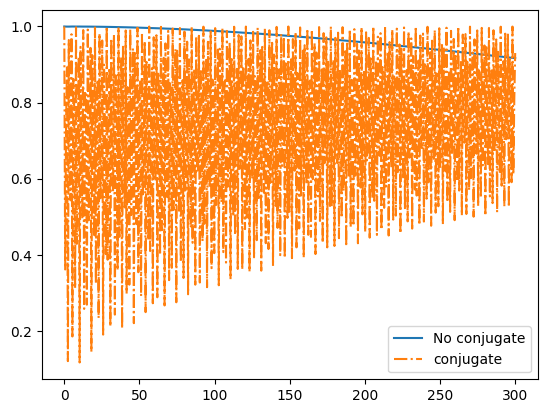

In [34]:
plt.plot(times,f,label="No conjugate")
plt.plot(times,fcon,label="conjugate",linestyle="-.")
plt.legend()

### Also seems like I should take no conjugate, however if one takes the following Hamiltonian and coupling operators (it also happens for a model I considered in my old code, and the spin chains I'm considering. This example is from the SYK model)
#### Same steps as before

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (
    basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, destroy, tensor,
    fidelity, tracedist, brmesolve, Qobj)
from qutip.solver import heom

In [2]:
H=Qobj(np.diag([-.109,.109,.109,-.109]))*20 #the times 20 is to rescale time

In [3]:
H

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[-2.18  0.    0.    0.  ]
 [ 0.    2.18  0.    0.  ]
 [ 0.    0.    2.18  0.  ]
 [ 0.    0.    0.   -2.18]]

In [4]:
Q=np.array([[0,0.53-0.707j,0.442-.471j,0],[0.53+0.707j,0,0,-0.442+.471j],[0.442+.471j,0,0,0.53-0.707j],[0,-0.442-.471j,0.53+0.707j,0]]) # coupling operator non trivial like in the shinsey ryu paper. This difference is not dramatic for simpler couplings
Q=Qobj(Q)
Q

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 0.   +0.j     0.53 -0.707j  0.442-0.471j  0.   +0.j   ]
 [ 0.53 +0.707j  0.   +0.j     0.   +0.j    -0.442+0.471j]
 [ 0.442+0.471j  0.   +0.j     0.   +0.j     0.53 -0.707j]
 [ 0.   +0.j    -0.442-0.471j  0.53 +0.707j  0.   +0.j   ]]

In [30]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#Same bath as DSE but with Temperature
print(E01) 
w0=1#1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
print(w0)
gamma=1#w0/2.05
print(gamma)
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)
print(lam)
lam
N=2

4.36
1
1
True
0.9306048591020996


In [22]:
# change the initial state to be away from the ground state
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1)
# change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0 = psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims

In [23]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=2, Nk=5) # fix runtime warning
times = np.linspace(0,300,500)

In [24]:
solver = heom.HEOMSolver(H,
                          [bath], max_depth=3, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.0%. Run time:   4.71s. Est. time left: 00:00:00:42
20.0%. Run time:   9.05s. Est. time left: 00:00:00:36
30.1%. Run time:  13.45s. Est. time left: 00:00:00:31
40.1%. Run time:  17.65s. Est. time left: 00:00:00:26
50.1%. Run time:  21.77s. Est. time left: 00:00:00:21
60.1%. Run time:  26.11s. Est. time left: 00:00:00:17
70.1%. Run time:  30.30s. Est. time left: 00:00:00:12
80.2%. Run time:  34.54s. Est. time left: 00:00:00:08
90.2%. Run time:  38.68s. Est. time left: 00:00:00:04
100.0%. Run time:  42.52s. Est. time left: 00:00:00:00
Total run time:  42.52s


In [25]:
T=2
UD = (
    f"2 * {lam}**2 * {gamma} / ( {w0}**4 * {1/T}) if (w==0)"
    " else "
    f"2 * ({lam}**2 * {gamma} * w / (({w0}**2 - w**2)**2 + {gamma}**2 * w**2))"
    f" * ((1 / (exp(w * {1/T}) - 1)) + 1)"
)

In [26]:
a_ops = [[Q, UD]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

In [27]:
f=np.array([ fidelity(resultBR.states[k],state) for k,state in enumerate(result.states)])
fcon=np.array([ fidelity(resultBR.states[k].trans(),state) for k,state in enumerate(result.states)])

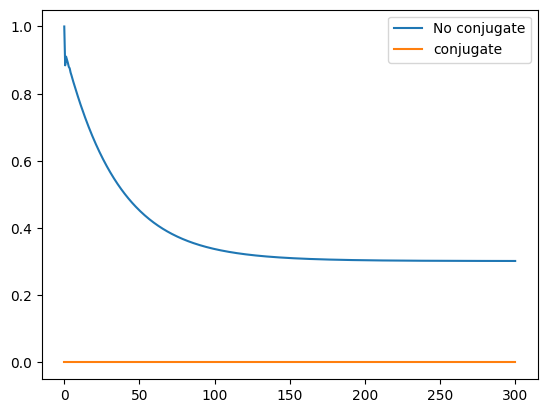

In [29]:
plt.plot(times,f,label="No conjugate")
plt.plot(times,fcon,label="conjugate")
plt.legend()

In [31]:
result.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 3.80956690e-01-8.71312156e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.14197393e-01+8.71986657e-02j]
 [ 0.00000000e+00+0.00000000e+00j  7.43727624e-02+1.53095590e-17j
  -2.41438015e-16-7.43727624e-02j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -3.61935387e-16+7.43727624e-02j
   7.43727624e-02+1.87751199e-17j  0.00000000e+00+0.00000000e+00j]
 [-4.14197393e-01-8.71986657e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.70297785e-01+5.50396588e-17j]]

In [32]:
resultBR.states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', isherm=True
Qobj data =
[[ 4.96341713e-01+1.21281560e-14j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.37134620e-01+9.20275122e-02j]
 [ 0.00000000e+00+0.00000000e+00j  5.08025788e-02-4.43996928e-14j
   1.08643220e-14-5.08025788e-02j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -7.33585992e-15+5.08025788e-02j
   5.08025788e-02+4.40426270e-14j  0.00000000e+00+0.00000000e+00j]
 [ 4.37134620e-01-9.20275122e-02j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.02053129e-01-1.17861680e-14j]]

### Could it be that small values in the density matrix ruin fidelity calculations? let's round to discard that

In [96]:
heomround=[Qobj(i.full().round(10)) for i in result.states]
brround=[Qobj(i.full().round(10)) for i in resultBR.states]

In [97]:
f=np.array([ fidelity(brround[k],state) for k,state in enumerate(heomround)])
fcon=np.array([ fidelity(brround[k].trans(),state) for k,state in enumerate(heomround)])


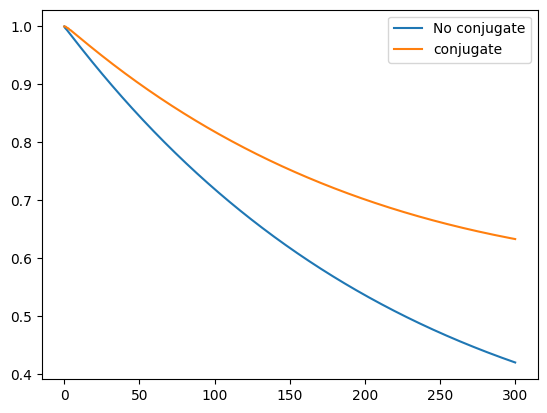

In [98]:
plt.plot(times,f,label="No conjugate")
plt.plot(times,fcon,label="conjugate")
plt.legend()
plt.show()

In [99]:
import qutip

In [100]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.0.dev0+bacf463
Numpy Version:      2.0.0
Scipy Version:      1.14.0
Cython Version:     3.0.10
Matplotlib Version: 3.9.1
Python Version:     3.12.3
Number of CPUs:     8
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/mcditoos/github/qutip_gsoc_app/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generate